In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC, SVR
from sklearn.metrics import accuracy_score

In [2]:
# Load data
x_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")
x_test = np.load("x_test.npy")
y_test = np.load("y_test.npy")

In [3]:
# 7000 data with 300 features
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)

(7000, 300)
(7000,)
(3000, 300)


In [4]:
# It's a binary classification problem 
print(np.unique(y_train))

[0 1]


# Q1

In [5]:
def cross_validation(x_train, y_train, k=5):
    kfold_data = []
    n_samples = x_train.shape[0]
    # shuffle
    all_idxs = np.random.RandomState(seed=43).permutation(n_samples)
    # handle the situation if n_samples is not divisible by k
    fold_sizes = np.full(k, n_samples // k)
    fold_sizes[:n_samples % k] += 1
    folds = np.split(all_idxs, np.cumsum(fold_sizes)[:-1])
    for i in range(k):
        train_val_pair = []
        val_idxs = folds[i]
        train_idxs = np.concatenate(folds[:i] + folds[i+1:])
        train_val_pair.append(train_idxs)
        train_val_pair.append(val_idxs)
        kfold_data.append(train_val_pair)
    
    return kfold_data

In [6]:
kfold_data = cross_validation(x_train, y_train, k=10)
assert len(kfold_data) == 10 # should contain 10 fold of data
assert len(kfold_data[0]) == 2 # each element should contain train fold and validation fold
assert kfold_data[0][1].shape[0] == 700 # The number of data in each validation fold should equal to training data divieded by K

# K-Fold Example

In [7]:
from sklearn.model_selection import KFold

X = np.arange(20)

kf = KFold(n_splits=5, shuffle=True)
kfold_data= []
for i, (train_index, val_index) in enumerate(kf.split(X)):
    print("Split: %s, Training index: %s, Validation index: %s" % (i+1, train_index, val_index))
    kfold_data.append([train_index, val_index])

Split: 1, Training index: [ 0  1  3  4  5  6  8  9 10 11 12 13 14 16 17 18], Validation index: [ 2  7 15 19]
Split: 2, Training index: [ 0  2  4  5  6  7  8  9 11 12 13 15 16 17 18 19], Validation index: [ 1  3 10 14]
Split: 3, Training index: [ 0  1  2  3  4  6  7  8  9 10 11 13 14 15 16 19], Validation index: [ 5 12 17 18]
Split: 4, Training index: [ 1  2  3  4  5  7  9 10 11 12 14 15 16 17 18 19], Validation index: [ 0  6  8 13]
Split: 5, Training index: [ 0  1  2  3  5  6  7  8 10 12 13 14 15 17 18 19], Validation index: [ 4  9 11 16]


In [8]:
assert len(kfold_data) == 5 # should contain 5 fold of data
assert len(kfold_data[0]) == 2 # each element should contains index of training fold and validation fold
assert kfold_data[0][1].shape[0] == 4 # The number of data in each validation fold should equal to training data divieded by K

## Q2

In [9]:
# (Example) Using SVC from sklearn
clf = SVC(C=1.0, gamma=0.01, kernel='rbf')

In [10]:
best_c, best_gamma = None, None
c_range = [0.01,0.1,1]
gamma_range = [0.0001,0.001,0.01]

grid_search = np.zeros((len(c_range), len(gamma_range)))
k = 5
prev_accuracy = 0

kfold_data = cross_validation(x_train, y_train, k)

for c_index, c in enumerate(c_range):
    for gamma_index, gamma in enumerate(gamma_range):
        scores = []
        for i in range(k):
            train_idxs, val_idxs = kfold_data[i]
            x_train_fold = x_train[train_idxs]
            y_train_fold = y_train[train_idxs]
            x_val_fold = x_train[val_idxs]
            y_val_fold = y_train[val_idxs]
            model = SVC(kernel='rbf',C=c,gamma=gamma)
            model.fit(x_train_fold,y_train_fold)
            pred_svm = model.predict(x_val_fold)
            accuracy = accuracy_score(pred_svm,y_val_fold)
            scores.append(accuracy)
        accuracy = np.mean(scores)
        grid_search[c_index][gamma_index] = accuracy
        if accuracy > prev_accuracy:
            prev_accuracy = accuracy
            best_c, best_gamma = c, gamma

best_parameters=(best_c, best_gamma)

# Q3

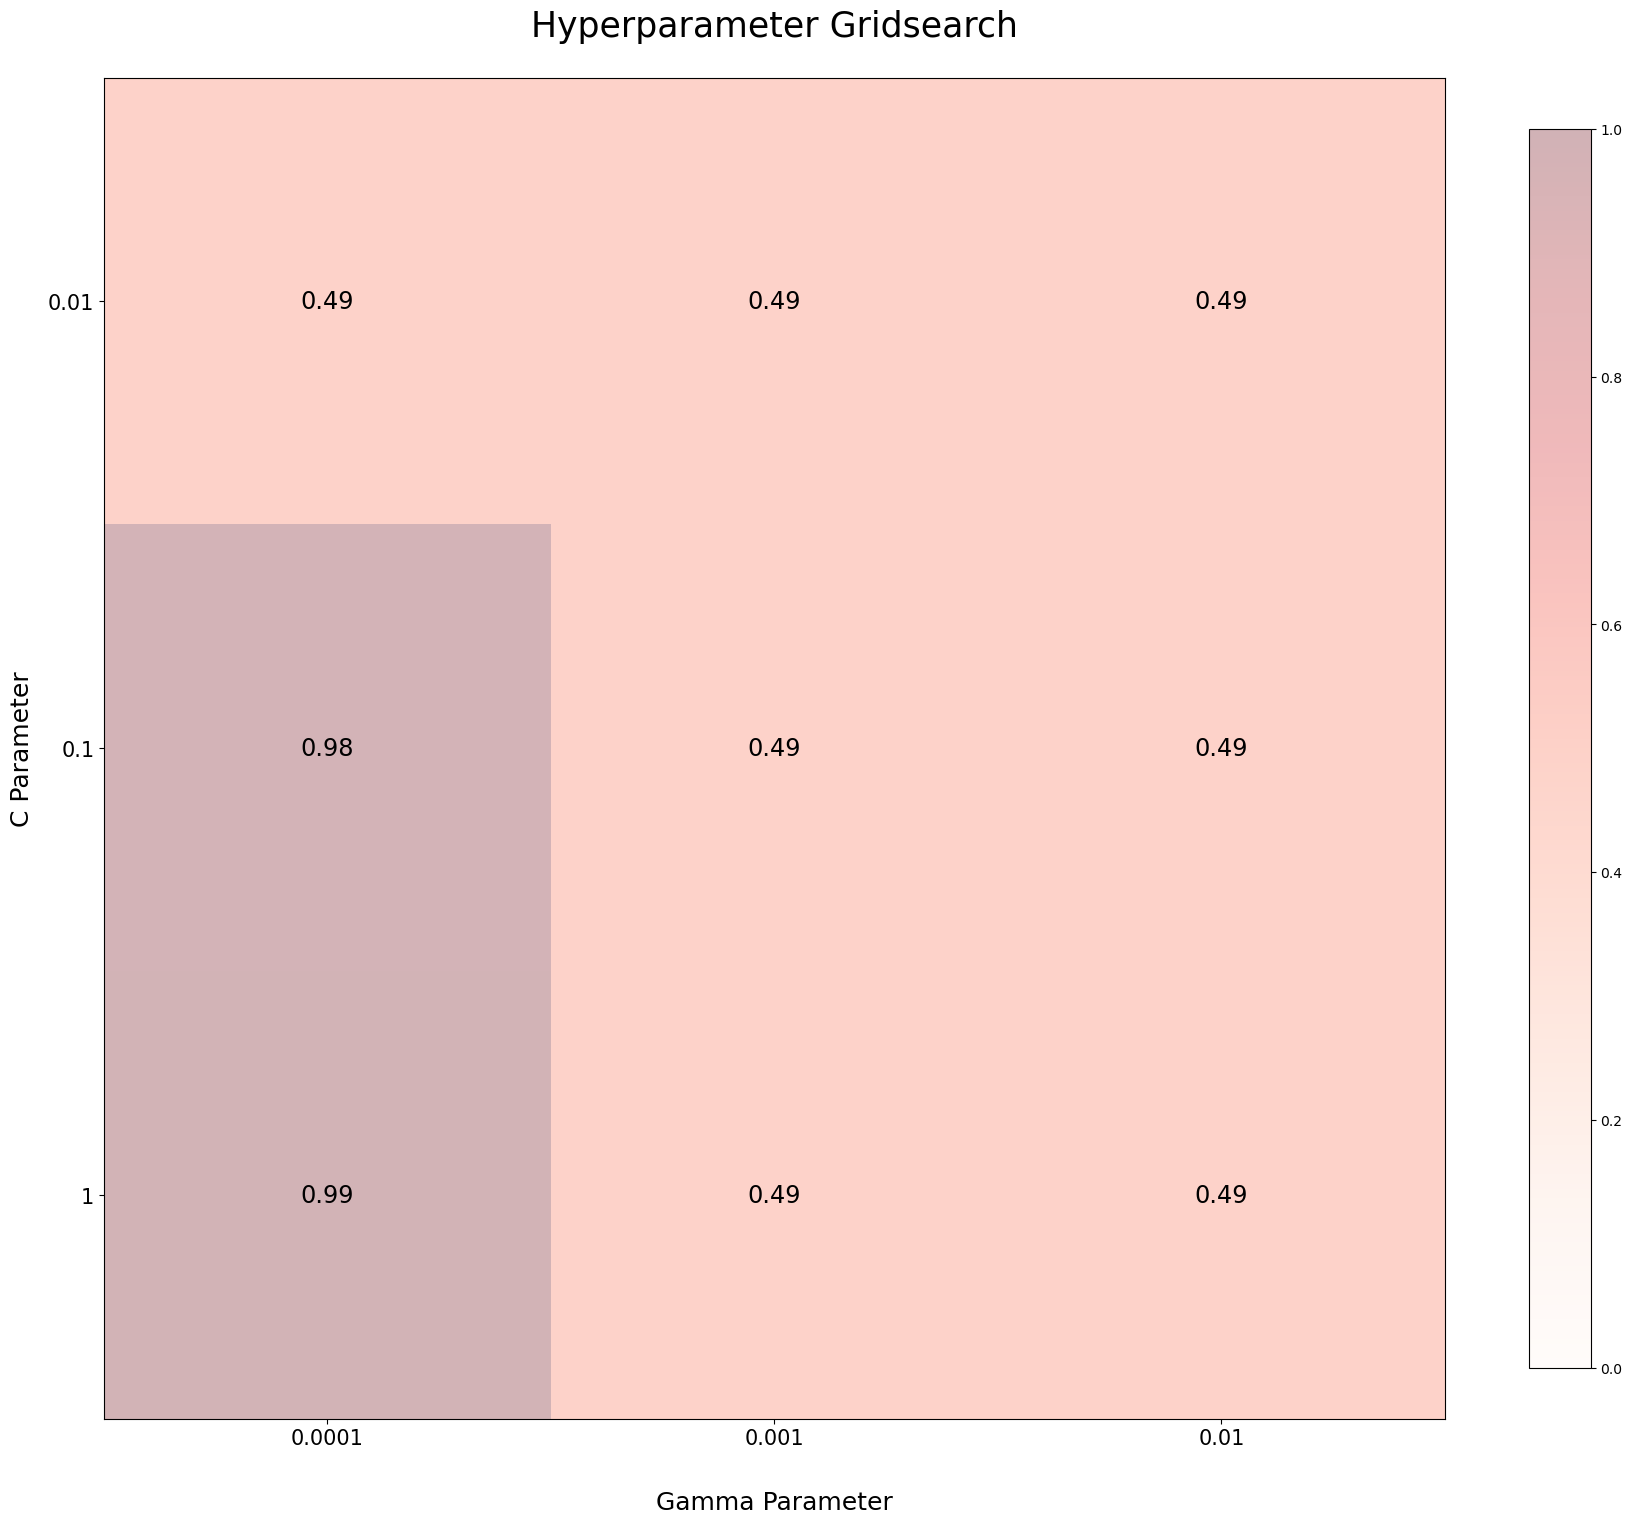

In [11]:
# Plot the grid search results of your SVM

fig, ax = plt.subplots(figsize=(18, 18))
# vmin, vmax 設定 color bar 的上下限
grid_search_plot = ax.matshow(grid_search, cmap=plt.cm.Reds, alpha=0.3, vmin = 0, vmax = 1.0)
ax.set_xticks(np.arange(len(gamma_range)), gamma_range, )
ax.set_yticks(np.arange(len(c_range)), c_range)
ax.tick_params(axis="both", bottom=True, top=False, labelbottom=True, labeltop=False, labelsize=15)
for i in range(grid_search.shape[0]):
		for j in range(grid_search.shape[1]):
				ax.text(x=j, y=i,s="{:.2f}".format(grid_search[i][j]), va='center', ha='center', size='xx-large')

fig.colorbar(grid_search_plot, shrink=0.7)
plt.xlabel('Gamma Parameter', fontsize=18, labelpad=30)
plt.ylabel('C Parameter', fontsize=18, labelpad=10)
plt.title('Hyperparameter Gridsearch', fontsize=25, pad=30)
plt.tight_layout()
plt.show()

## Q4

In [12]:
# Do Not Modify Below
best_model = SVC(C=best_parameters[0], gamma=best_parameters[1], kernel='rbf')
best_model.fit(x_train, y_train)

y_pred = best_model.predict(x_test)

print("Accuracy score: ", accuracy_score(y_pred, y_test))

# If your accuracy here > 0.9 then you will get full credit (20 points).

Accuracy score:  0.995
